<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Keras
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, TimeDistributed, Dropout, Conv1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Common imports
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Parameters
window_hours = 168 #24*7
forecast_hours = 24
traing_hours = 24*365*2
test_hours = 24*365

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function for plot
def plot_learning_curves(loss, val_loss, x_min_max=None, y_min_max=None):
    if x_min_max is None and y_min_max is None:
        x_min_max = [1,100]
        y_min_max = [0,70]
        
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([x_min_max[0], x_min_max[1], y_min_max[0], y_min_max[1]])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
#Read csv file
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
df=df.dropna()

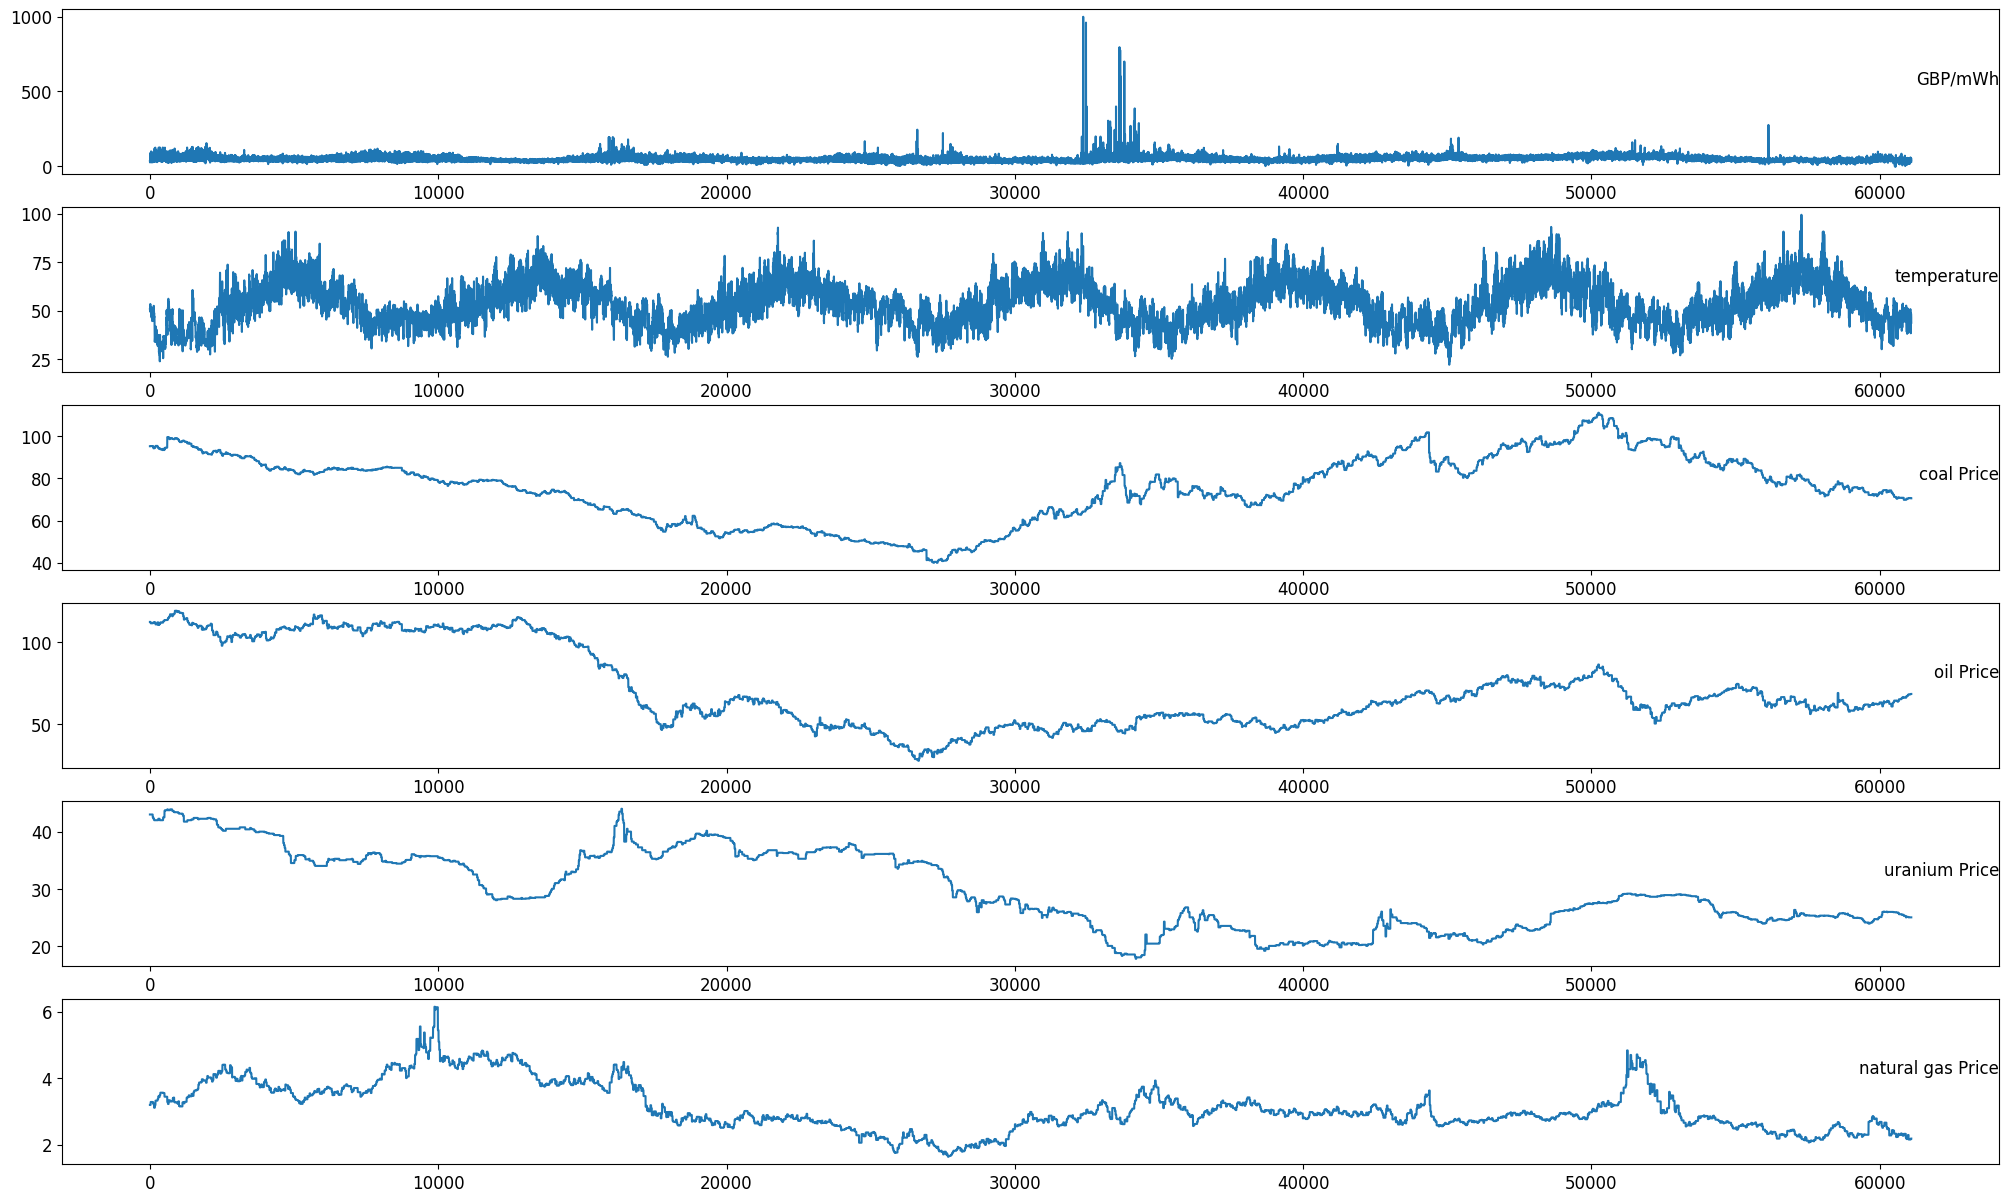

In [3]:
#Plot graph
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
# Normalize Datafram
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [6]:
# 192hours time window (n_step+24)
series_reshaped =  np.array([data[i:i + (window_hours+forecast_hours)].copy() for i in range(len(data) - (window_hours+forecast_hours))])
print(series_reshaped.shape)

(60905, 192, 6)


In [7]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Train, valid, test data 만들기
X_train = series_reshaped[:traing_hours, :window_hours]
X_valid = series_reshaped[traing_hours:series_reshaped.shape[0]-test_hours, :window_hours]
X_test = series_reshaped[series_reshaped.shape[0]-test_hours:, :window_hours]
Y = np.empty((series_reshaped.shape[0], window_hours, forecast_hours))

for step_ahead in range(1, forecast_hours + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + window_hours, 0]
Y_train = Y[:traing_hours]
Y_valid = Y[traing_hours:series_reshaped.shape[0]-test_hours]
Y_test = Y[series_reshaped.shape[0]-test_hours:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(17520, 168, 6) (34625, 168, 6) (8760, 168, 6) (17520, 168, 24) (34625, 168, 24) (8760, 168, 24)


#Note#
X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

Deep Multivariate Recurrant Neural Network

In [20]:
#Training 

model6 = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    SimpleRNN(50, return_sequences=True),
    TimeDistributed(keras.layers.Dense(forecast_hours))
])

n_epochs = 100
es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 10)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])

Epoch 1/100
548/548 [==============================] - 30s 53ms/step - loss: 44.4838 - val_loss: 45.6894
Epoch 2/100
548/548 [==============================] - 29s 52ms/step - loss: 20.7074 - val_loss: 40.6492
Epoch 3/100
548/548 [==============================] - 28s 52ms/step - loss: 18.8461 - val_loss: 40.1972
Epoch 4/100
548/548 [==============================] - 28s 52ms/step - loss: 17.9704 - val_loss: 36.3539
Epoch 5/100
548/548 [==============================] - 28s 52ms/step - loss: 16.5664 - val_loss: 36.2057
Epoch 6/100
548/548 [==============================] - 29s 54ms/step - loss: 15.5717 - val_loss: 33.7816
Epoch 7/100
548/548 [==============================] - 29s 52ms/step - loss: 15.2564 - val_loss: 29.3382
Epoch 8/100
548/548 [==============================] - 29s 52ms/step - loss: 15.8045 - val_loss: 28.0785
Epoch 9/100
548/548 [==============================] - 28s 52ms/step - loss: 13.7978 - val_loss: 24.8223
Epoch 10/100
548/548 [==============================] -

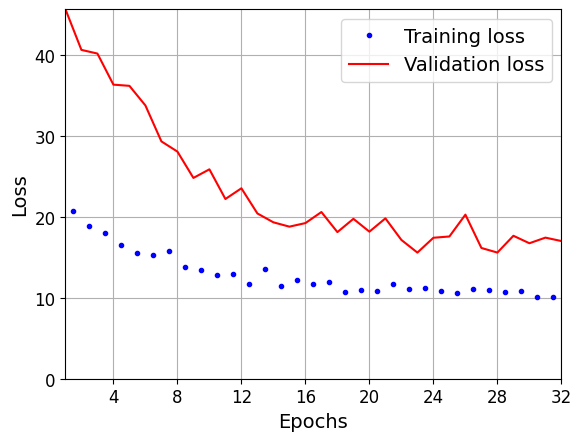

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

In [23]:
#Predict

Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual1 = actual

274/274 [==============================] - 3s 11ms/step


Simple Long-Short Term Memory Model

In [24]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model8 = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 40
model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid))

Epoch 1/40
548/548 [==============================] - 28s 48ms/step - loss: 32.8862 - val_loss: 45.5697
Epoch 2/40
548/548 [==============================] - 26s 47ms/step - loss: 17.4904 - val_loss: 35.4111
Epoch 3/40
548/548 [==============================] - 26s 48ms/step - loss: 16.5050 - val_loss: 30.7862
Epoch 4/40
548/548 [==============================] - 26s 48ms/step - loss: 15.5164 - val_loss: 27.8280
Epoch 5/40
548/548 [==============================] - 25s 46ms/step - loss: 14.5838 - val_loss: 27.4594
Epoch 6/40
548/548 [==============================] - 25s 46ms/step - loss: 13.9488 - val_loss: 27.0583
Epoch 7/40
548/548 [==============================] - 25s 46ms/step - loss: 13.4868 - val_loss: 25.7645
Epoch 8/40
548/548 [==============================] - 26s 47ms/step - loss: 13.1208 - val_loss: 25.3895
Epoch 9/40
548/548 [==============================] - 26s 47ms/step - loss: 12.7949 - val_loss: 24.5647
Epoch 10/40
548/548 [==============================] - 25s 46ms/

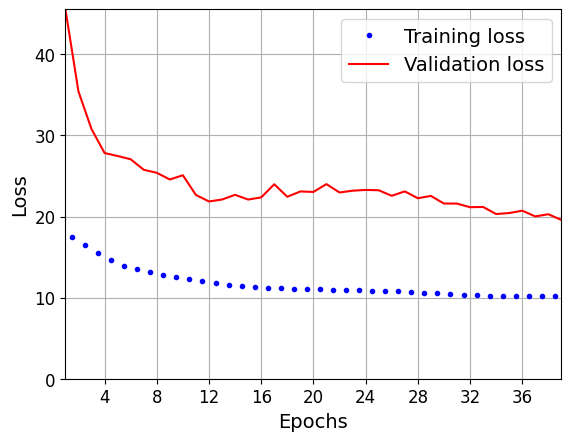

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

In [27]:
#Predict

Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual2 = actual

274/274 [==============================] - 3s 9ms/step


Deep LSTM model

In [28]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model9 = Sequential([
    LSTM(80, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(40, return_sequences=True),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 20
model9.compile(loss="mape", optimizer="adam")
es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 10)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history = model9.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks = [es,mc])

Epoch 1/20
548/548 [==============================] - 109s 193ms/step - loss: 17.4167 - val_loss: 19.0784
Epoch 2/20
548/548 [==============================] - 106s 194ms/step - loss: 13.3332 - val_loss: 16.8015
Epoch 3/20
548/548 [==============================] - 112s 204ms/step - loss: 12.2099 - val_loss: 17.7564
Epoch 4/20
548/548 [==============================] - 110s 201ms/step - loss: 11.3905 - val_loss: 18.2340
Epoch 5/20
548/548 [==============================] - 110s 200ms/step - loss: 10.8025 - val_loss: 18.9989
Epoch 6/20
548/548 [==============================] - 111s 203ms/step - loss: 10.5104 - val_loss: 18.8630
Epoch 7/20
548/548 [==============================] - 112s 204ms/step - loss: 10.2900 - val_loss: 17.2547
Epoch 8/20
548/548 [==============================] - 108s 198ms/step - loss: 10.0991 - val_loss: 17.6972
Epoch 9/20
548/548 [==============================] - 109s 200ms/step - loss: 9.9494 - val_loss: 19.0041
Epoch 10/20
548/548 [==========================

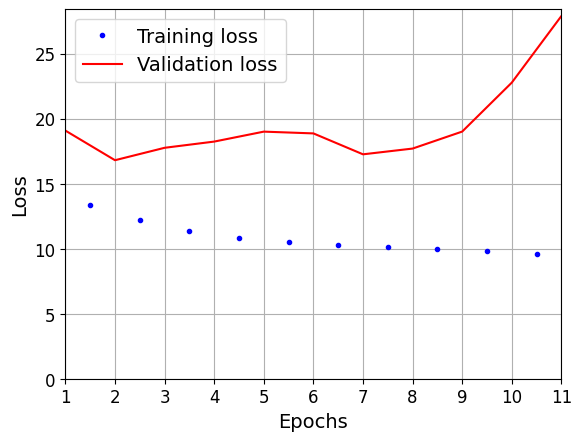

In [29]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

Conv1D?

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model10 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, X_train.shape[2]]),
    GRU(60, return_sequences=True),
    GRU(40, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 20
model10.compile(loss="mape", optimizer="adam")
es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 10)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es,mc])